In [1]:
# -*- coding: utf-8 -*- 
"""
Created on Tuesday Feb  25

@author: Dr. Benjamin Vien

Demonstration:
"""

## TO INSTALL
# !pip install torch torchvision
# !pip install imageio
# !pip install matplotlib
# !pip install imageio[ffmpeg]

import os
# Set the environment variables 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Libraries
import torch
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import time
import scipy.io as sio
from torch.cuda.amp import autocast  # For mixed precision
from main_utils import save_video_tensor, extend_tensor_along_time,queryref_points,checkframes,processingframe,plot_single_frame_with_gradient,plot_single_frame_with_gradient_visibility
print('Okay')

Okay


CUDA available: True
CUDA device count: 4
CUDA device name: NVIDIA A10G


Using cache found in /home/sagemaker-user/.cache/torch/hub/facebookresearch_co-tracker_main


GitHub CoTracker3 is using device: cuda
Loaded fine-tuned model weights.
--------------------------------------------------------------
Loaded MAT Query Points
<class 'torch.Tensor'>
torch.Size([1024, 2, 483])
Query Points for Frame 0: torch.Size([1024, 3])
Final Combined Tensor Shape: torch.Size([1, 1024, 3])
--------------------------------------------------------------
Video Loading.....


/tmp/ipykernel_4119/1292431249.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./model_saved/cotracker3_finetuned_AWS_v1SYN_freezeFNET_1000samp

Video Loaded!
Creating Video Tensor...
Completed Video Tensor!
Before NaN removal: torch.Size([1, 1024, 3])
No NaN
After NaN removal: torch.Size([1, 1024, 3])
Starting - Displacement Tracker
AutoCast
Using Query Points


/tmp/ipykernel_4119/1292431249.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Elapsed time: 3.913628 seconds
--------------------------------------------------------------
Frame min: 0.0 Frame max: 255.0
Frame min: 0.0 Frame max: 1.0


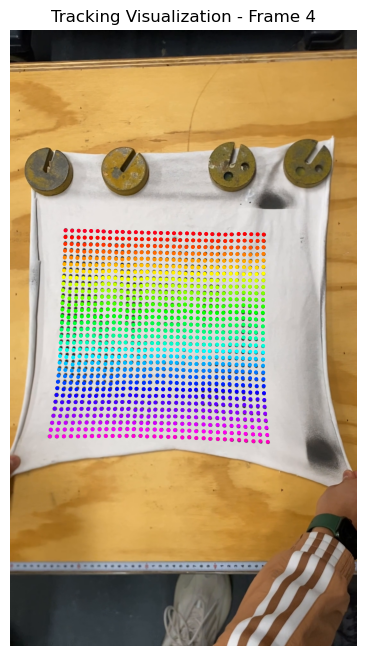

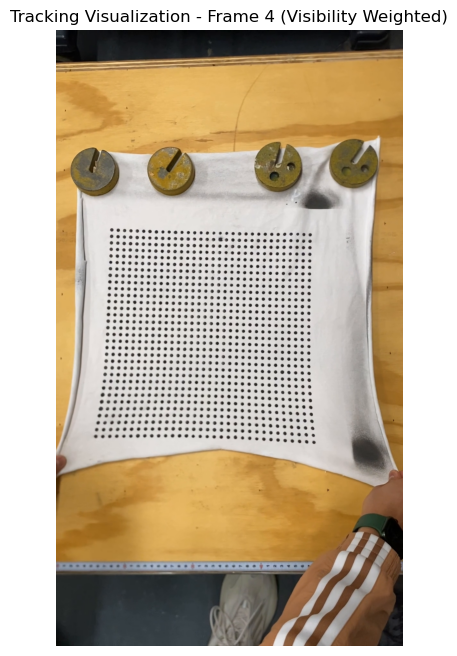

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 1920) to (1088, 1920) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ./saved_videos/ImageTracker/video.mp4


In [2]:
 
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' #Forced
torch.cuda.empty_cache()

#%% Call Offline Mode: Load the Model
use_local = False #Use False less GPU memory...
if not use_local:
    cotracker = torch.hub.load('facebookresearch/co-tracker', 'cotracker3_offline').to(device)
    print(f"GitHub CoTracker3 is using device: {device}")
else:
    cotracker = torch.hub.load('./co-tracker', 'cotracker3_offline', source='local').to(device)
    print(f"Local CoTracker3 is using device: {device}")

# Option to load saved fine-tuned weights:
reload_model = True
if reload_model:
    state_dict = torch.load("./model_saved/cotracker3_finetuned_AWS_v1SYN_freezeFNET_1000samplesEPOCH25.pth", map_location=device)
    cotracker.load_state_dict(state_dict)
    # For further retraining set to train(), for inference use eval()
    cotracker.eval()
    del state_dict
    print("Loaded fine-tuned model weights.")

print("--------------------------------------------------------------")
# Have Query Points
have_qpoints = True
have_refpoints = False

combined_tensor,saved_objC_tensor,ref_points=queryref_points(have_qpoints,have_refpoints,170,device)

#%% Video Loading
print("--------------------------------------------------------------")
print("Video Loading.....")
video_path = './Input Files/IMG_7296.mp4'
frames = iio.imread(video_path, plugin='FFMPEG')
print("Video Loaded!")

#%% Optional: Check Frame Image (for debugging)
check_frame = False
checkframes(check_frame,frames,400,have_qpoints,have_refpoints,saved_objC_tensor,None)

#%% Create Video Tensor
combined_tensor,video_tensor=processingframe(frames,170,480,2,combined_tensor,device)

#%% Run the Tracker with Option for Autocast
print("Starting - Displacement Tracker")
tic = time.time()
use_autocast = True  # Set to True to use mixed precision inference via autocast
if use_autocast:
    print("AutoCast")
    with torch.cuda.amp.autocast():
        if have_qpoints or have_refpoints:
            print("Using Query Points")
            pred_tracks, pred_visibility = cotracker(video_tensor, queries=combined_tensor)
        else:
            print("Using Grid Points")
            pred_tracks, pred_visibility = cotracker(video_tensor, grid_size=40)
else:
    print("No AutoCast")
    if have_qpoints or have_refpoints:
        print("Using Query Points")
        pred_tracks, pred_visibility = cotracker(video_tensor, queries=combined_tensor)
    else:
        print("Using Grid Points")
        pred_tracks, pred_visibility = cotracker(video_tensor, grid_size=40)
toc = time.time()
elapsed_time = toc - tic
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print("--------------------------------------------------------------")

pred_tracks_np = pred_tracks[0].cpu().numpy()  # Shape: [T, N, 2]
#%%

frame_index = 4
plot_single_frame_with_gradient(video_tensor, pred_tracks_np, frame_index)
plot_single_frame_with_gradient_visibility(video_tensor, pred_tracks_np, pred_visibility, frame_index)

#%% Save Data
to_save_data=True
if to_save_data:
#    data_to_save = {'video_tensor':video_tensor,'pred_tracks': pred_tracks, 'pred_visibility': pred_visibility}
#    torch.save(data_to_save, './saved_variables/MODEL_sXEPOCHX.pt')
    data_to_save = {'pred_tracks': pred_tracks, 'pred_visibility': pred_visibility}
    torch.save(data_to_save, './saved_variables/MODEL_RAW_FULL170480_2x.pt')
#%% Call CoTracker Visualizer
extra = 10
# Extend each tensor along the time dimension
#extended_video = extend_tensor_along_time(video_tensor, extra,1)
#extended_tracks = extend_tensor_along_time(pred_tracks, extra,1)
#extended_visibility = extend_tensor_along_time(pred_visibility, extra,1)

from cotracker.utils.visualizer import Visualizer
vis = Visualizer(save_dir="./saved_videos/ImageTracker", pad_value=0, linewidth=3,fps=10, show_first_frame=0, tracks_leave_trace=0)
vis.visualize(video_tensor, pred_tracks, pred_visibility)
#vis.visualize(extended_video, extended_tracks, extended_visibility)

just_empty=False
if just_empty:
    tensor0 = torch.zeros((1, 66, 1024))
    tensor1 = torch.zeros((1, 66, 1024,2))
    vis.visualize(extended_video, tensor1, tensor0)
#%%

# save_video_tensor(extended_video, "extended_video.mp4", fps=10, extra=0)